In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import binned_statistic_2d

In [ ]:
# exp_dir="./experiments/exp_5/sa_results/f3fd6414-4a14-4892-9d6f-f0436a06c9e6"   # baperga, rootbeta, lai, height
# exp_dir="./experiments/exp_4/sa_results/601e1cb7-813e-47b4-9082-5e88abc6a68f"   # baperga, height, n = 64
# exp_dir="./experiments/exp_3/sa_results/45e203d8-fe6c-45c1-835e-02362309b55e"   # rootBeta, n = 64
# exp_dir="./experiments/exp_2/sa_results/c627a389-44bc-46c0-be63-a95b435be31f"   # LAI, n = 64
# exp_dir="./experiments/exp_1/sa_results/edb41521-a30a-4393-bd31-4ac1daa4d7a6"   # LAI, rootBeta, n = 64
exp_dir="./experiments/exp_1/sa_results/b95bdbdc-c398-4c15-8b61-6b9f73c95164"     # LAI, rootBeta, n = 1000
# exp_dir="./experiments/exp_6/sa_results/ada74d24-f69e-4091-b91b-76d43e39e4cc"   # baperga
# exp_dir="./experiments/exp_7/sa_results/10072a52-95e1-4e43-af0d-931c48530e73"   # height

In [3]:
with open(f"{exp_dir}/problem.json") as f:
    problem = json.load(f)
out = np.load(f"{exp_dir}/model_output.npy")
sample = np.load(f"{exp_dir}/sample.npy")
with open(f"{exp_dir}/errors.json") as f:
    errors = json.load(f)

In [4]:
problem

{'num_vars': 2,
 'names': ['i_leafAreaIndex', 'i_rootBeta'],
 'bounds': [[1.88, 5.34], [0.1, 1]],
 'outputs': ['P-PD', 'P-MD', 'GW', 'K-plant', 'E-MD'],
 'plot_settings': {'start_day': 121,
  'end_day': 236,
  'average': False,
  'metric': 'mape'},
 'arguments': {'input': 'exp-1_sa-problem.json',
  'output': './exp_1',
  'model': '../../02_program_code',
  'workers': 30,
  'samples': 512,
  'pop': 1}}

In [5]:
T, N, D = out.shape # number of time outputs, number of samples, number of output dimensions
_, I = sample.shape # number of samples, number of input dimensions

In [6]:
t_range = range(1920, 2784) # predrought measurement stop and end via timestep
# t_range = range(0, T)

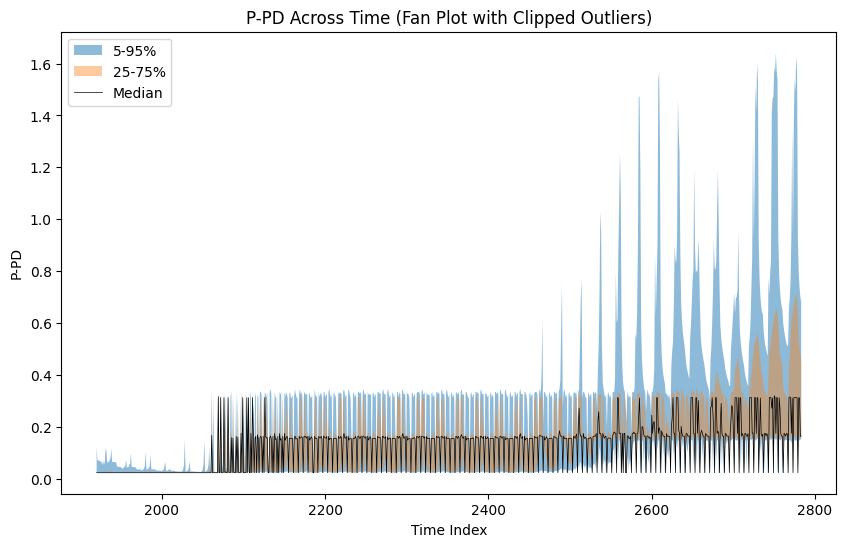

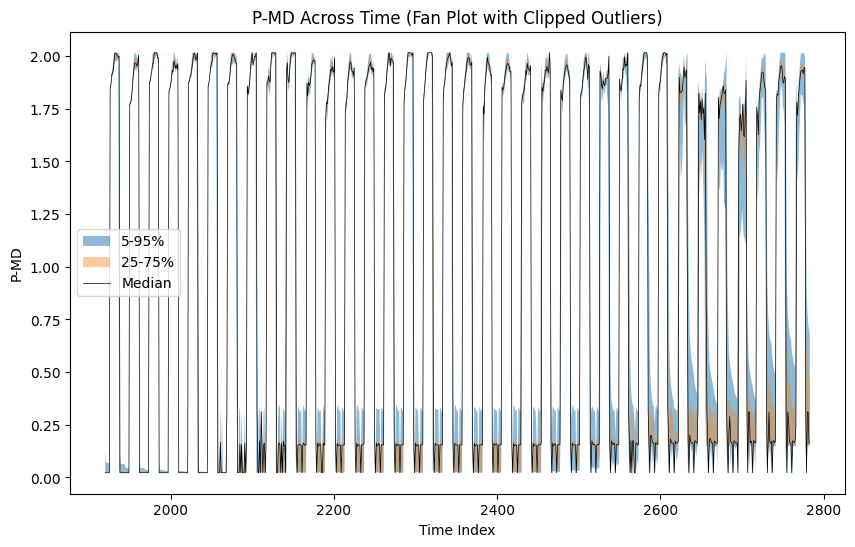

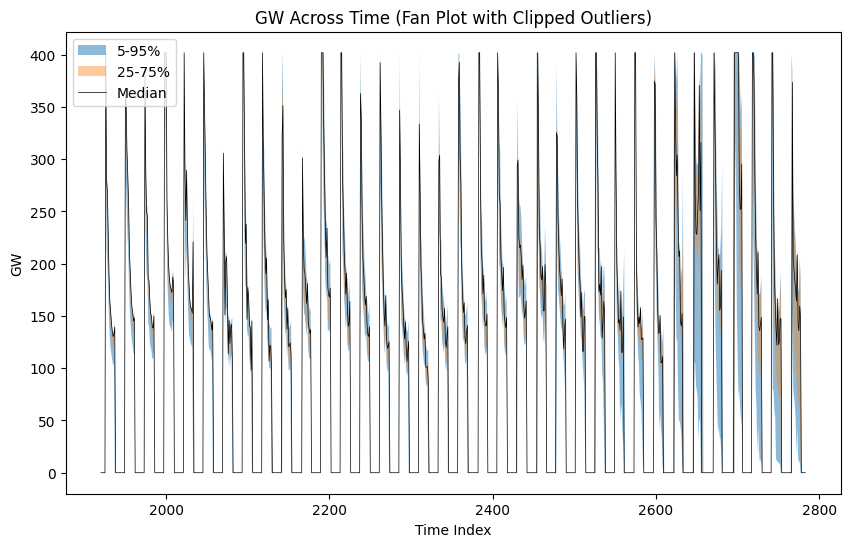

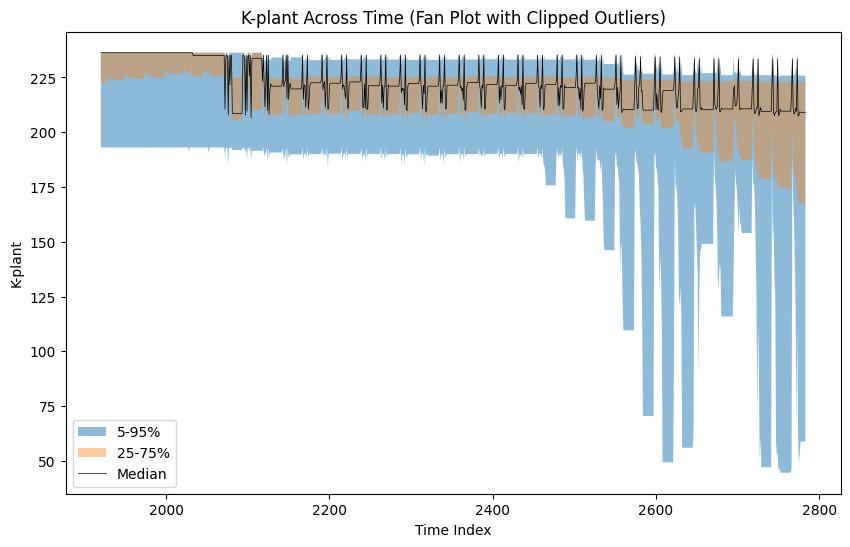

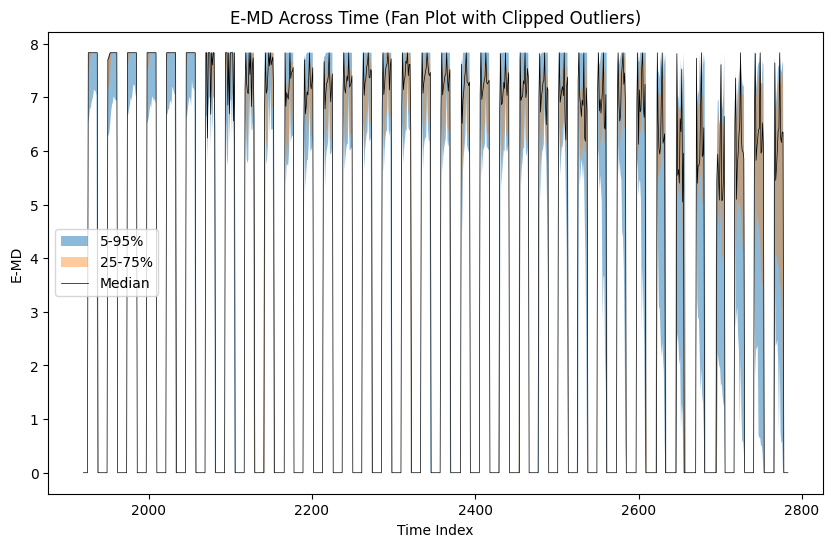

In [7]:
percentiles = [5, 25, 50, 75, 95]

for d in range(D):
    plt.figure(figsize=(10, 6))
    
    # Clip outliers
    clipped_out = np.clip(out[:, :, d], np.percentile(out[:, :, d], 5), np.percentile(out[:, :, d], 95))
    
    # Compute percentiles
    pct = np.percentile(clipped_out, q=percentiles, axis=1)  # shape [len(percentiles), T]
    
    # Fill between percentiles
    # Slice pct to match the length of t_range
    pct_sliced = pct[:, t_range.start:t_range.stop]
    
    plt.fill_between(t_range, pct_sliced[0], pct_sliced[-1], alpha=0.5, label='5-95%')
    plt.fill_between(t_range, pct_sliced[1], pct_sliced[-2], alpha=0.4, label='25-75%')
    
    # Plot median
    plt.plot(t_range, pct_sliced[2], color='black', linewidth=0.5, label='Median')
    
    plt.title(f'{problem["outputs"][d]} Across Time (Fan Plot with Clipped Outliers)')
    plt.xlabel('Time Index')
    plt.ylabel(f'{problem["outputs"][d]}')
    plt.legend()
    plt.show()

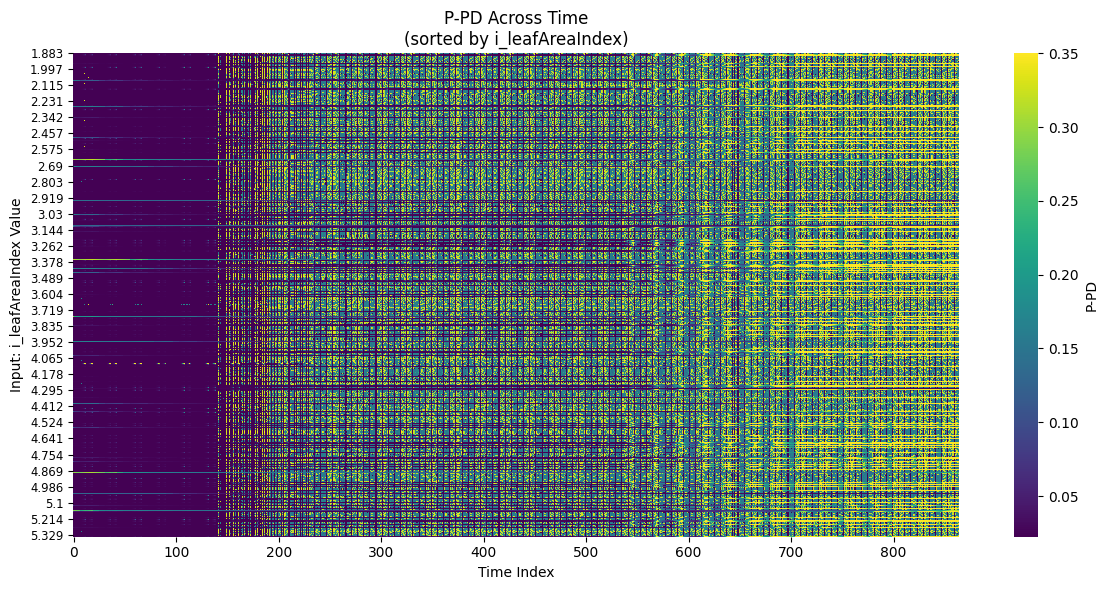

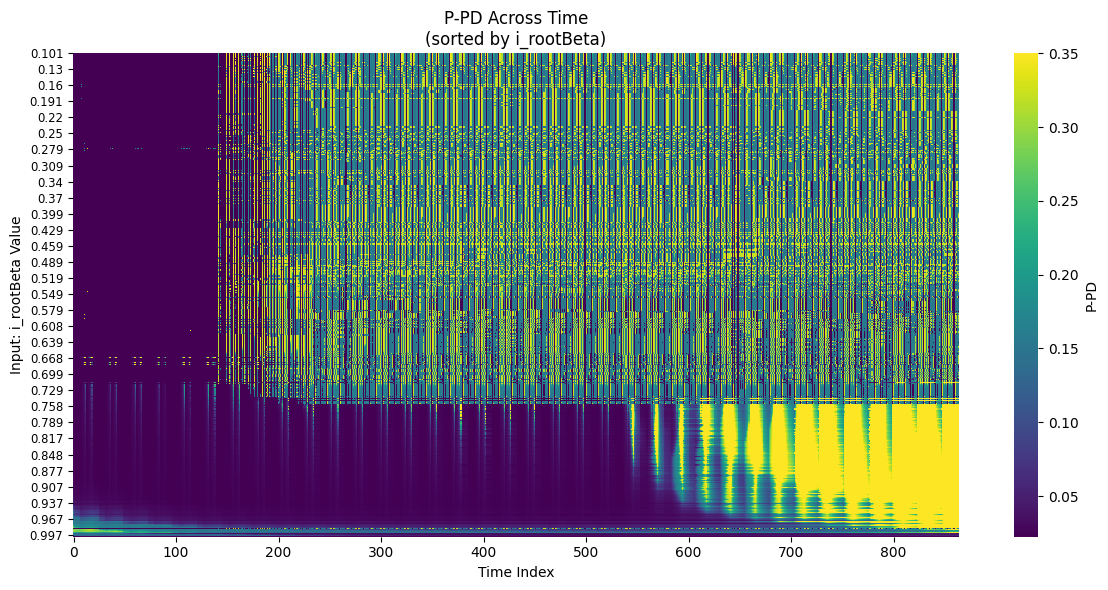

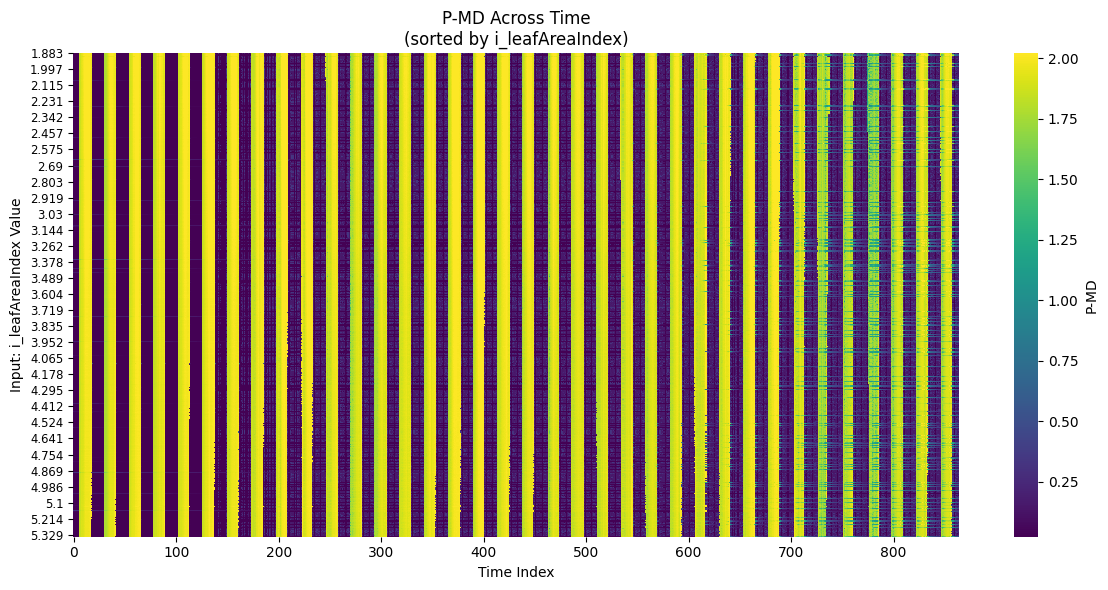

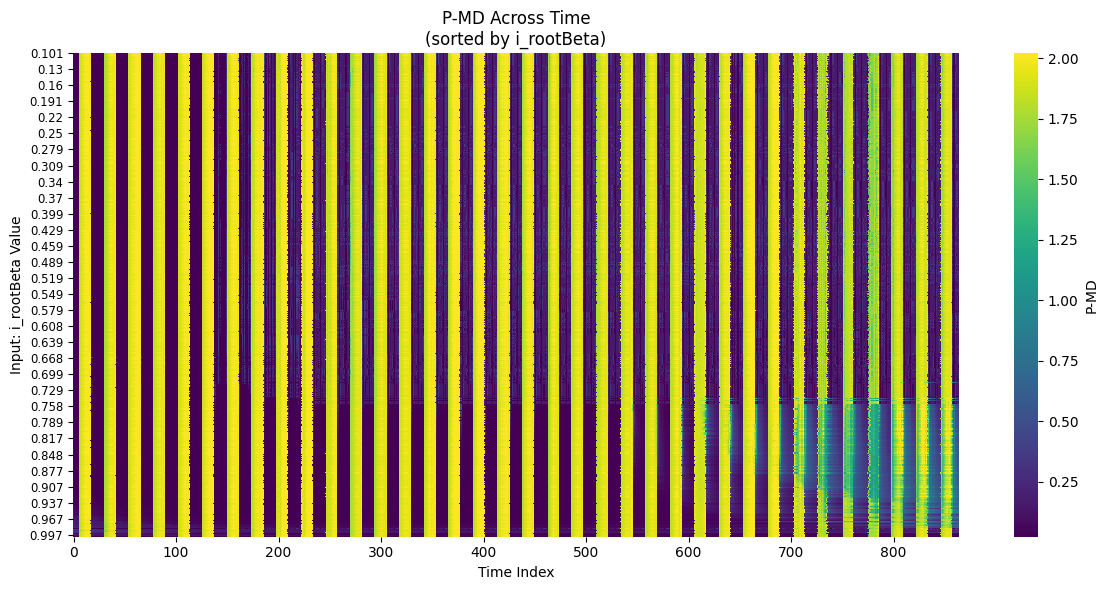

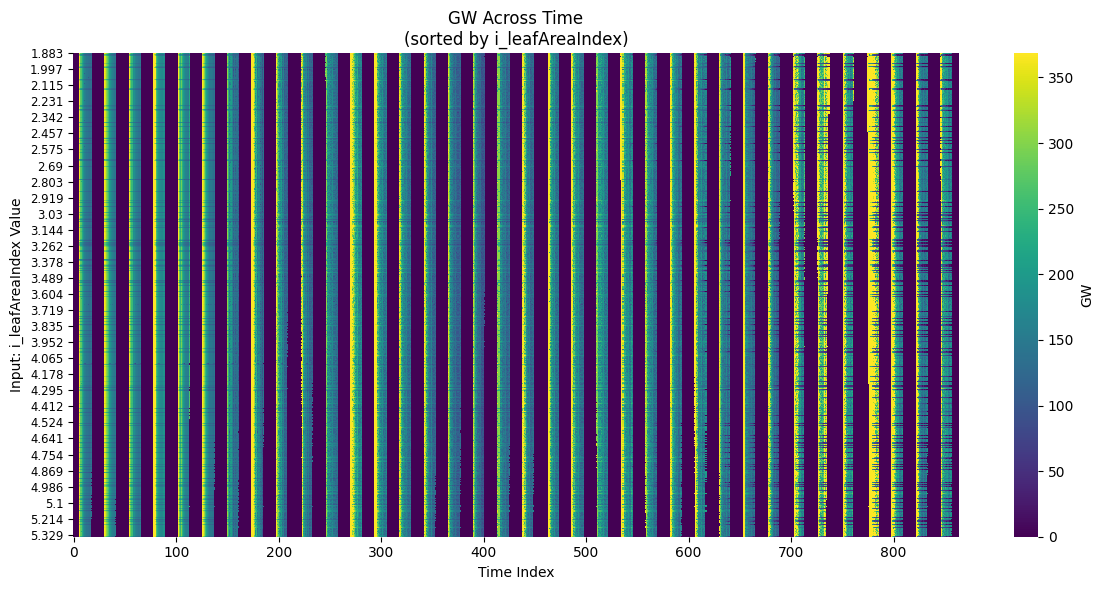

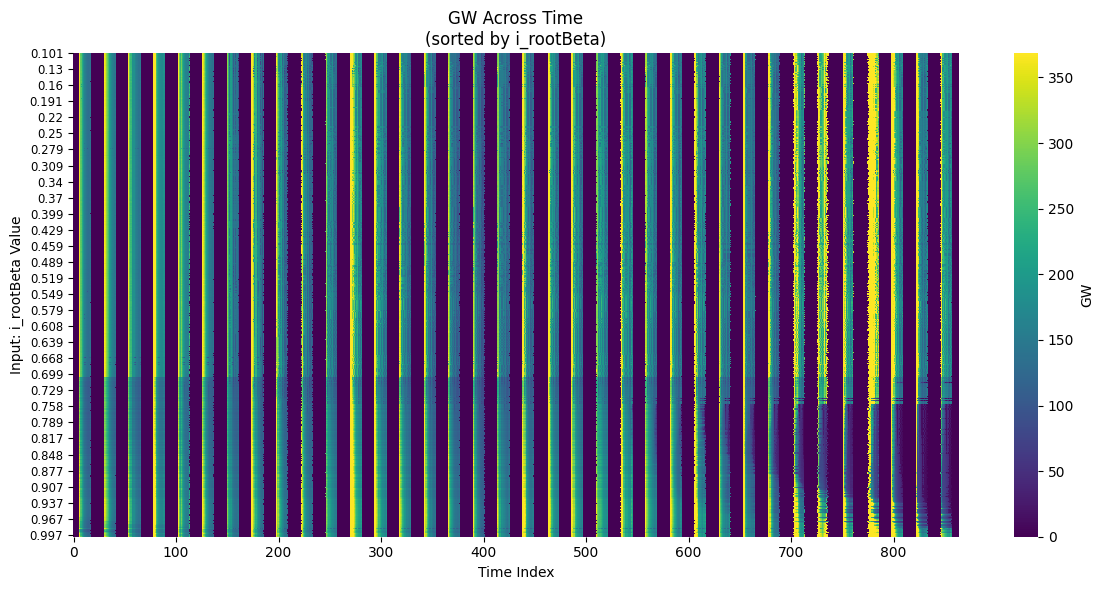

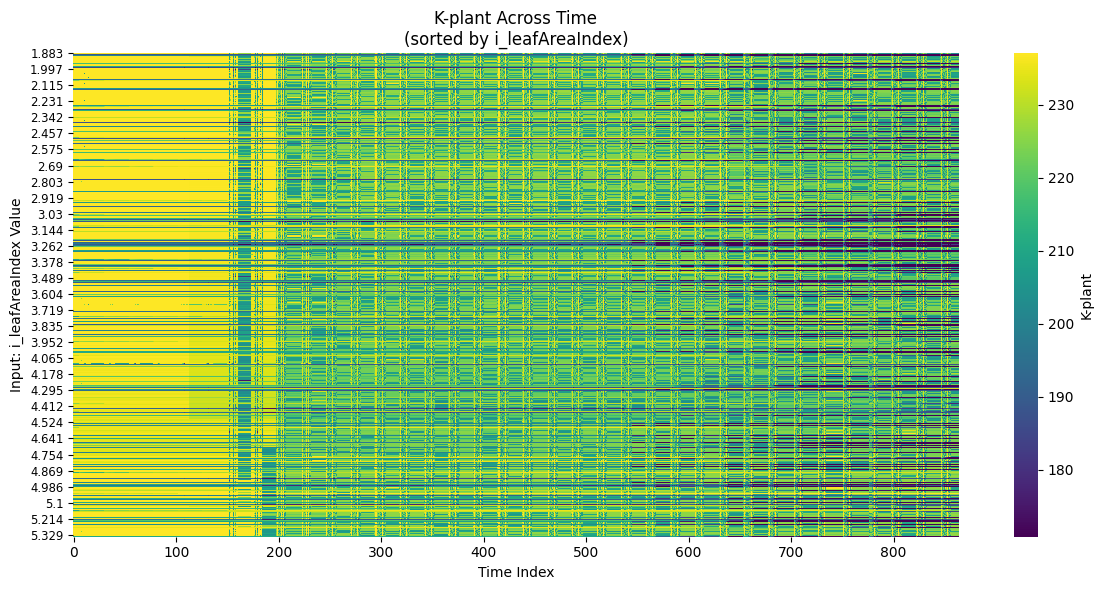

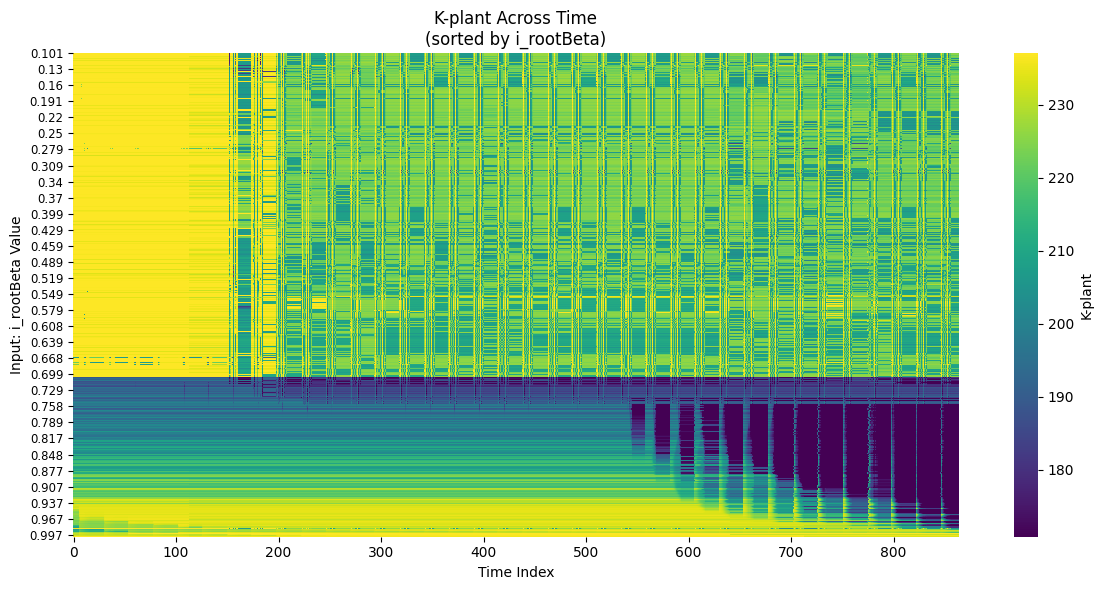

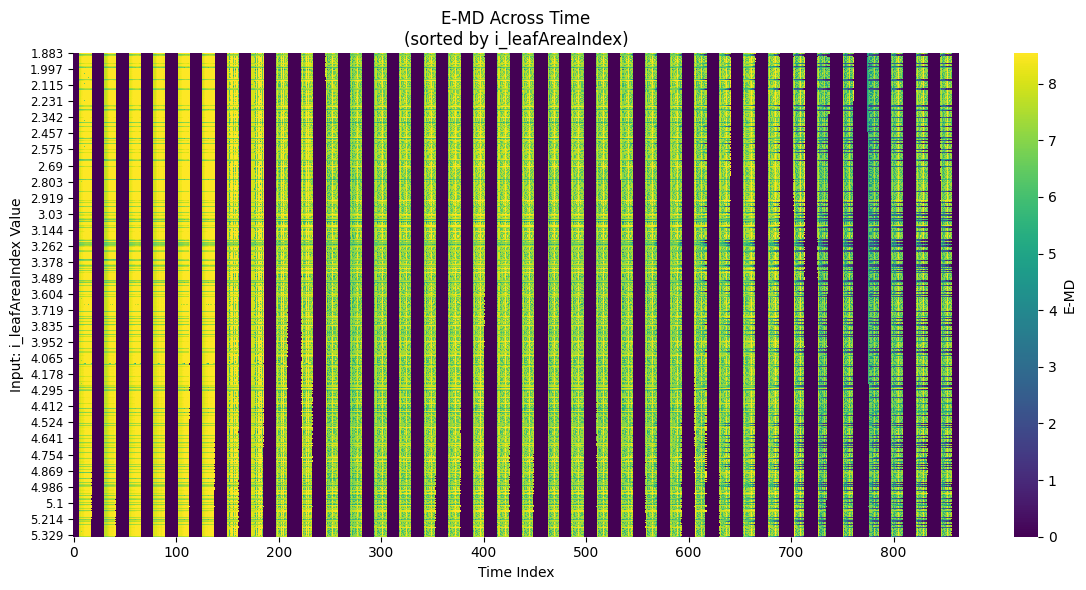

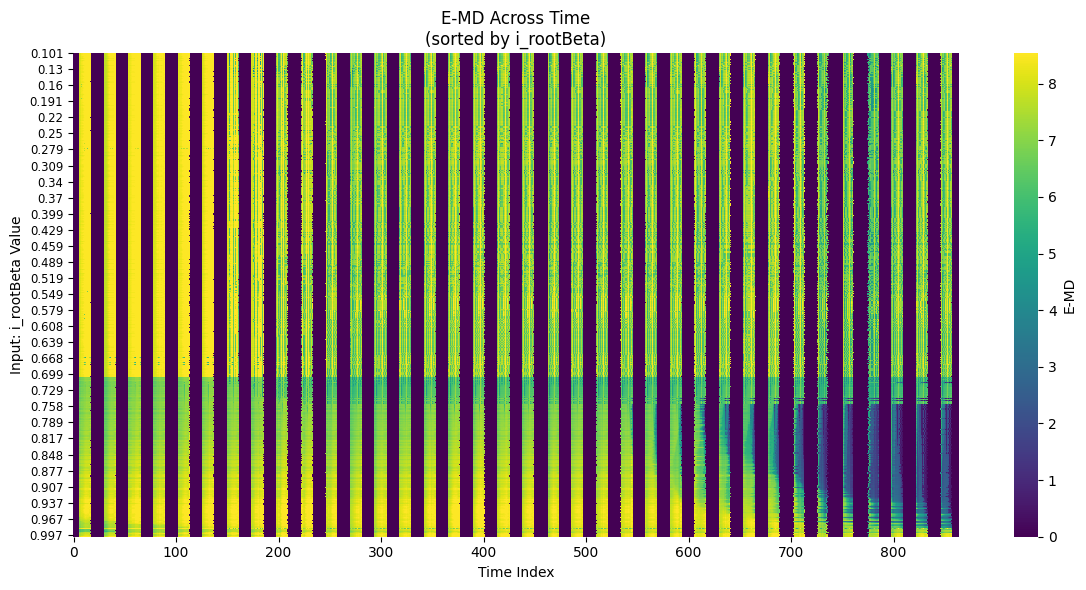

In [8]:
# out: shape (T, N, D)
# sample: shape (N, I)

for d in range(D):
    for i in range(I):
        plt.figure(figsize=(12, 6))
        
        # Sort samples by the i-th input parameter
        sorted_indices = np.argsort(sample[:, i])
        sorted_param_values = sample[sorted_indices, i]
        
        # Extract and sort model outputs accordingly
        output_slice = out[t_range.start:t_range.stop, sorted_indices, d]  # shape: (Tish, N)
        output_slice = np.clip(output_slice, np.percentile(output_slice, 5), np.percentile(output_slice, 95))
        
        # Reduce number of y-tick labels
        max_ticks = 30
        step = max(1, len(sorted_param_values) // max_ticks)
        y_tick_indices = np.arange(0, len(sorted_param_values), step)
        y_tick_labels = np.round(sorted_param_values[y_tick_indices], 3)

        ax = sns.heatmap(
            output_slice.T, # rows -> y-axis, columns -> x-axis, so transpose
            cmap='viridis',
            xticklabels=100,
            yticklabels=False,
            cbar_kws={'label': problem['outputs'][d]}
        )

        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels(y_tick_labels, rotation=0, fontsize='small')
        
        plt.title(f'{problem["outputs"][d]} Across Time\n(sorted by {problem["names"][i]})')
        plt.xlabel('Time Index')
        plt.ylabel(f'Input: {problem["names"][i]} Value')
        plt.tight_layout()
        plt.show()

In [9]:
# Heatmap averaging over timesteps for unique sample values
if problem['num_vars'] == 2:
    for d in range(D):
        plt.figure(figsize=(10, 8))

        # Extract parameter values
        param_x = sample[:, 0]
        param_y = sample[:, 1]
        unique_x = np.unique(param_x)
        unique_y = np.unique(param_y)

        # Initialize heatmap data
        aggregated_output = np.full((len(unique_y), len(unique_x)), np.nan)

        # Fill heatmap by averaging output at each (x, y) combo
        # Outputs so y is in row and x is in col
        for i, x_val in enumerate(unique_x):
            for j, y_val in enumerate(unique_y):
                idx = np.where((param_x == x_val) & (param_y == y_val))[0]
                if len(idx) > 0:
                    # Filter out zero values in the output array
                    filtered_out = np.where(out != 0, out, np.nan)
        
                    # Compute the mean over the specified range and dimension, ignoring NaN values
                    aggregated_output[j, i] = np.nanmedian(filtered_out[t_range.start:t_range.stop, idx, d])
                    # aggregated_output[j, i] = np.mean(out[t_range.start:t_range.stop, idx, d])

        # Optional: clip outliers to improve contrast
        lower, upper = np.nanpercentile(aggregated_output, [5, 95])
        aggregated_output = np.clip(aggregated_output, lower, upper)

        # Reduce number of y-tick and x-tick labels
        max_ticks = 30
        step_x = max(1, len(unique_x) // max_ticks)
        x_tick_indices = np.arange(0, len(unique_x), step_x)
        x_tick_labels = np.round(unique_x[x_tick_indices], 3)

        step_y = max(1, len(unique_y) // max_ticks)
        y_tick_indices = np.arange(0, len(unique_y), step_y)
        y_tick_labels = np.round(unique_y[y_tick_indices], 3)

        # Plot
        ax = sns.heatmap(
            aggregated_output,
            xticklabels=False,
            yticklabels=False,
            cmap='viridis',
            cbar_kws={'label': problem['outputs'][d]}
        )

        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels(y_tick_labels, rotation=0, fontsize='small')
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels(x_tick_labels, rotation=90, fontsize='small')

        ax.set_xlabel(f'Input: {problem["names"][0]}')
        ax.set_ylabel(f'Input: {problem["names"][1]}')
        ax.set_title(f'{problem["outputs"][d]} across Input Parameters')
        plt.tight_layout()
        plt.show()

KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

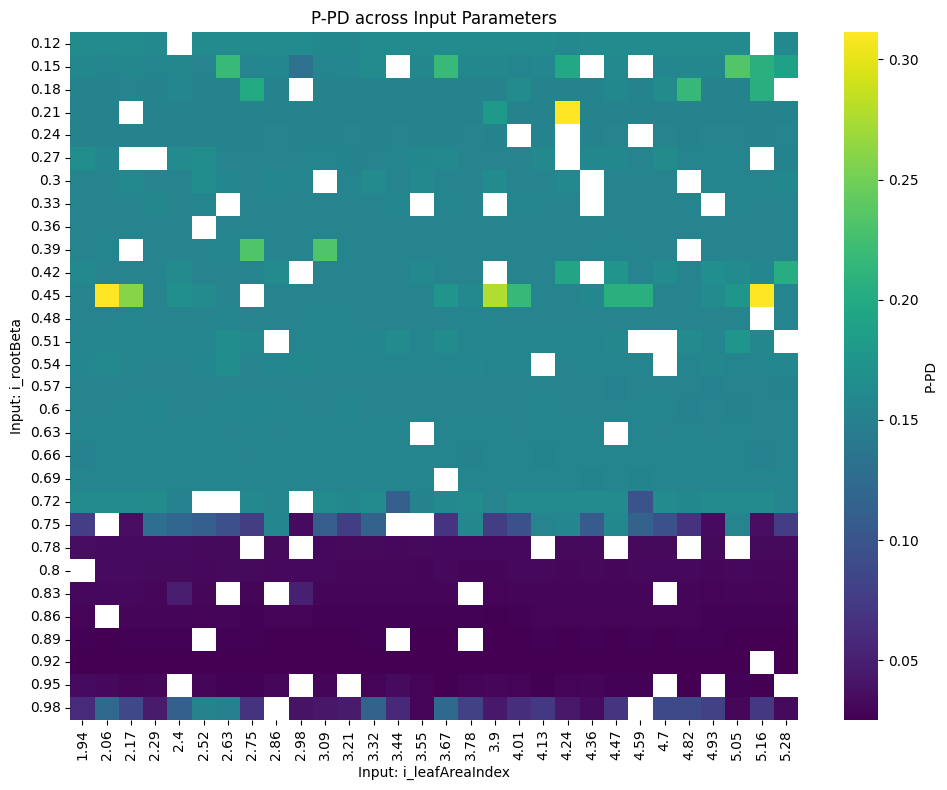

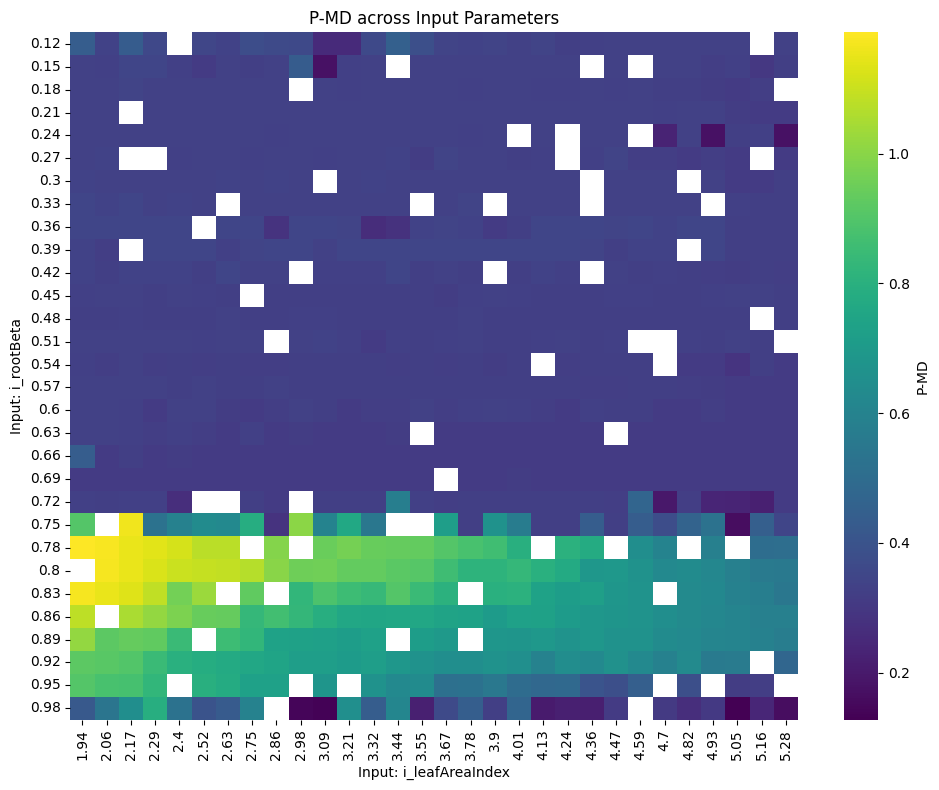

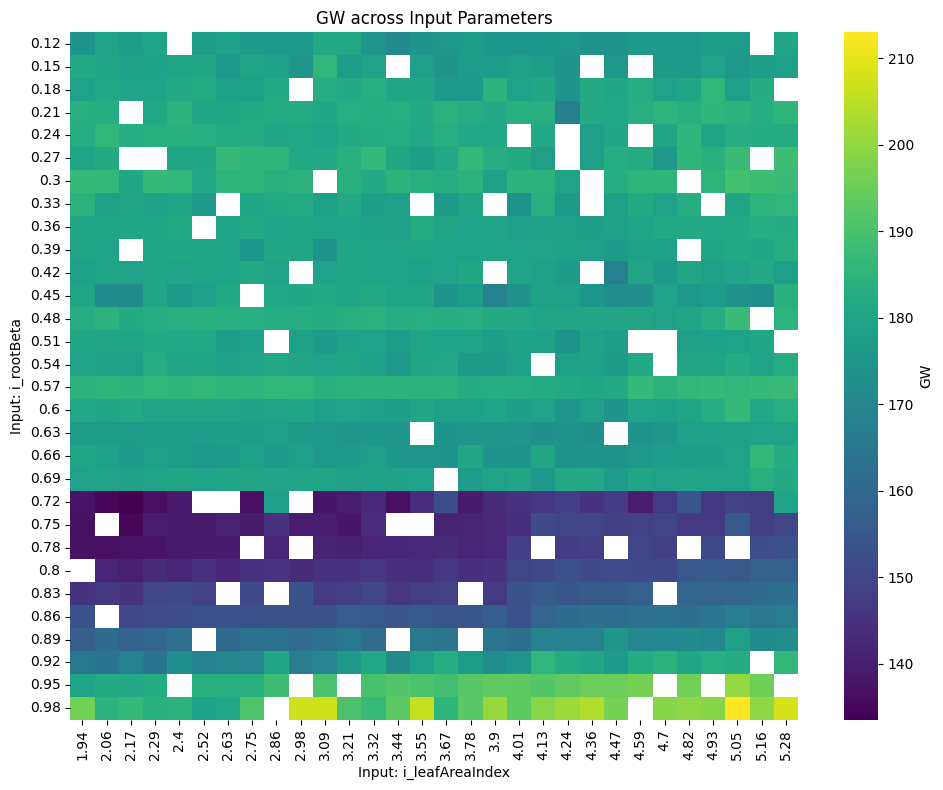

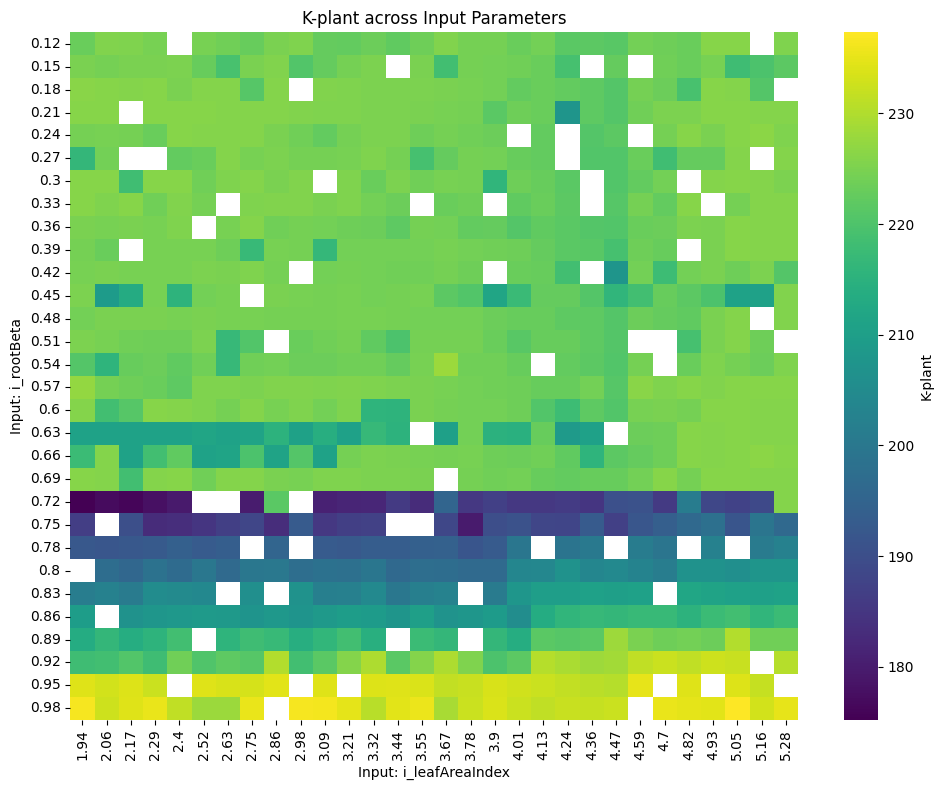

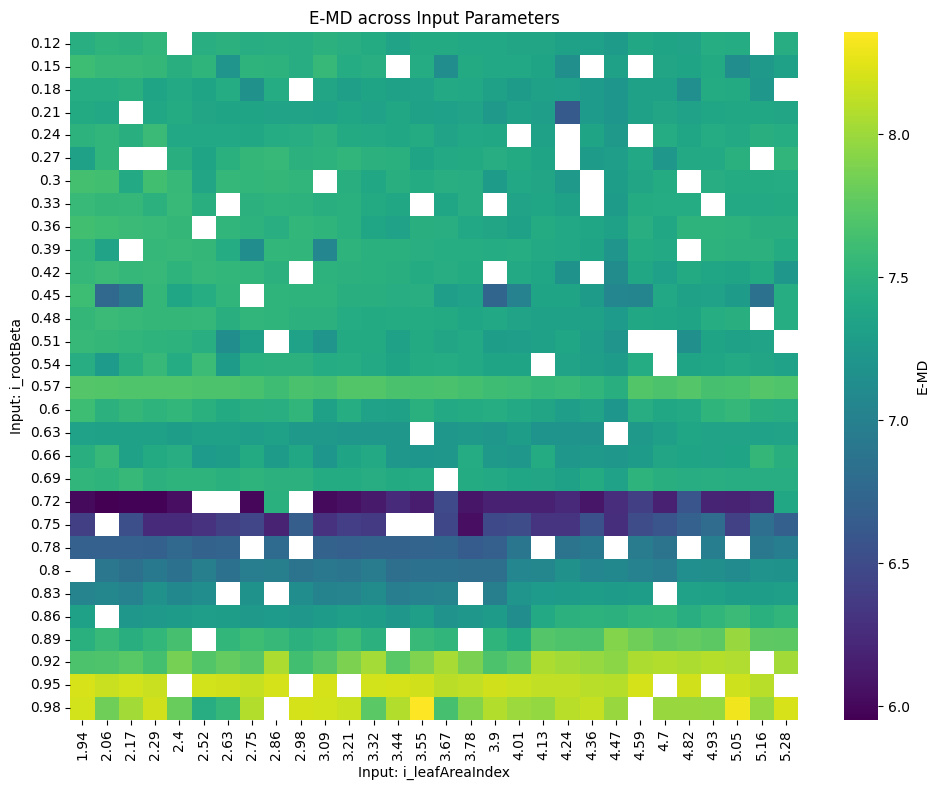

In [11]:
# Binned heatmap aggregating over the outputs and interpolating
bins = 30

if problem['num_vars'] == 2:
    for d in range(D):
        plt.figure(figsize=(10, 8))

        # Extract parameter values
        x = sample[:, 0]
        y = sample[:, 1]

        # Filter out zero values and clip in the output array
        filtered_out = np.where(out != 0, out, np.nan)
        # filtered_out = np.clip(filtered_out, np.nanpercentile(filtered_out, 5), np.nanpercentile(filtered_out, 95))
        
        # Compute the median over the specified range and dimension, ignoring NaN values
        z = np.nanmedian(filtered_out[t_range.start:t_range.stop, :, d], axis=0)

        # Compute mean within bins (parameter values)
        stat, x_edges, y_edges, binnumber = binned_statistic_2d(
            x, y, z, statistic='mean', bins=bins
        )

        # Reduce number of y-tick and x-tick labels
        x_tick_labels = np.round((x_edges[:-1] + x_edges[1:]) / 2, 2)
        y_tick_labels = np.round((y_edges[:-1] + y_edges[1:]) / 2, 2)

        # Plot
        ax = sns.heatmap(
            stat.T,
            xticklabels=x_tick_labels,
            yticklabels=y_tick_labels,
            cmap='viridis',
            cbar_kws={'label': problem['outputs'][d]}
        )

        ax.set_xlabel(f'Input: {problem["names"][0]}')
        ax.set_ylabel(f'Input: {problem["names"][1]}')
        ax.set_title(f'{problem["outputs"][d]} across Input Parameters')
        plt.tight_layout()
        # plt.show()

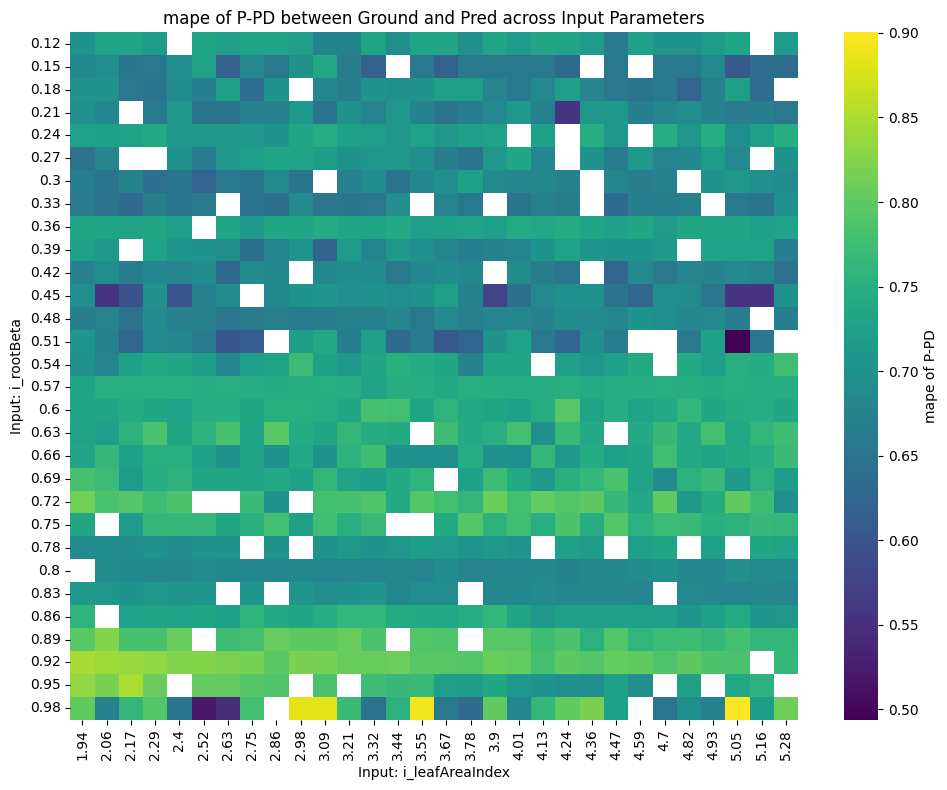

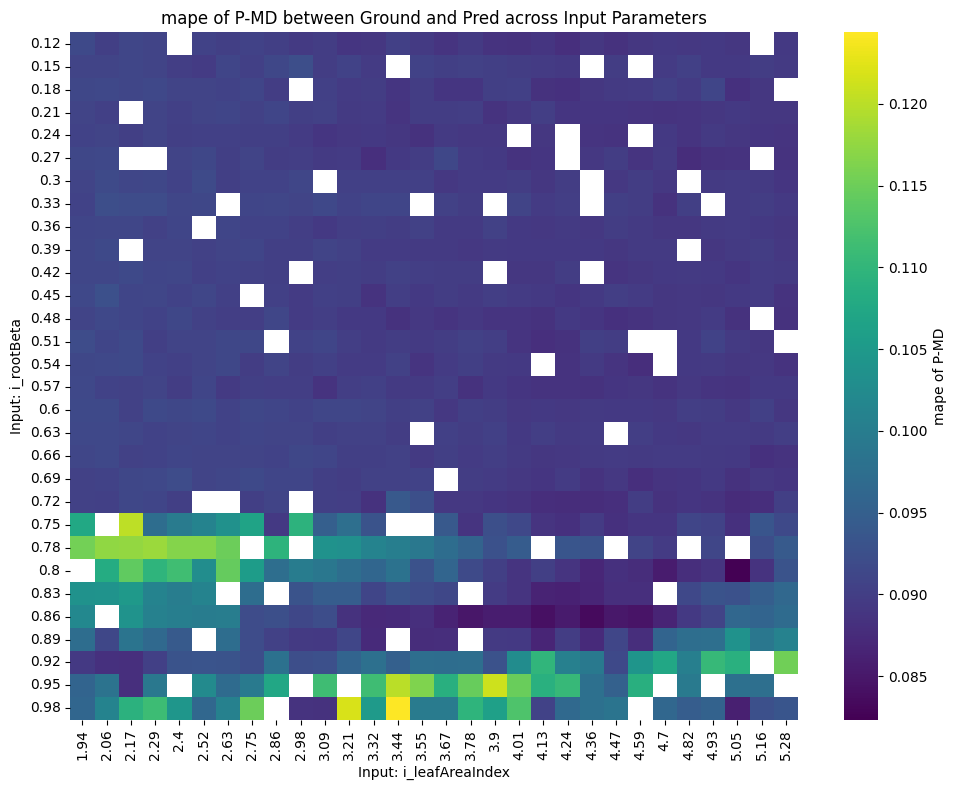

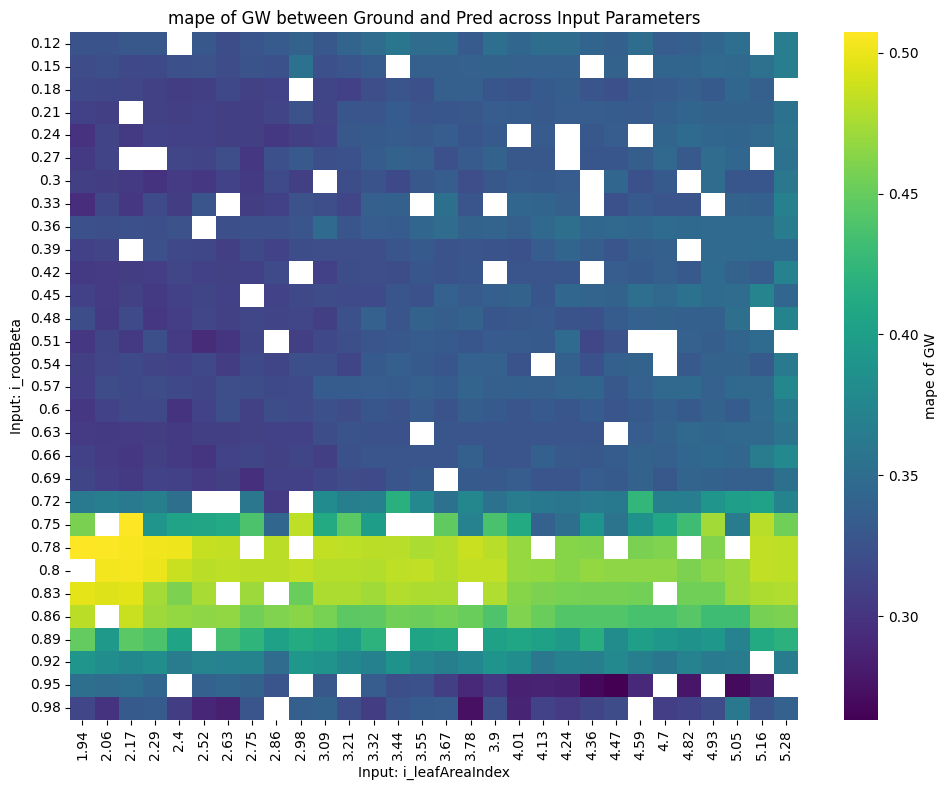

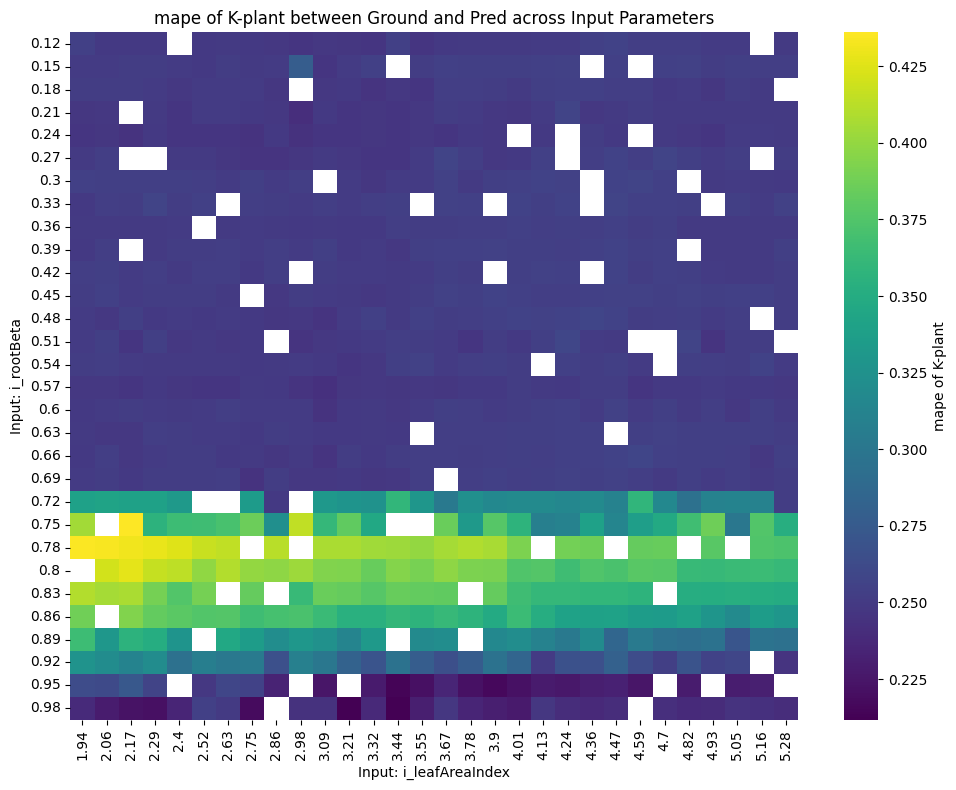

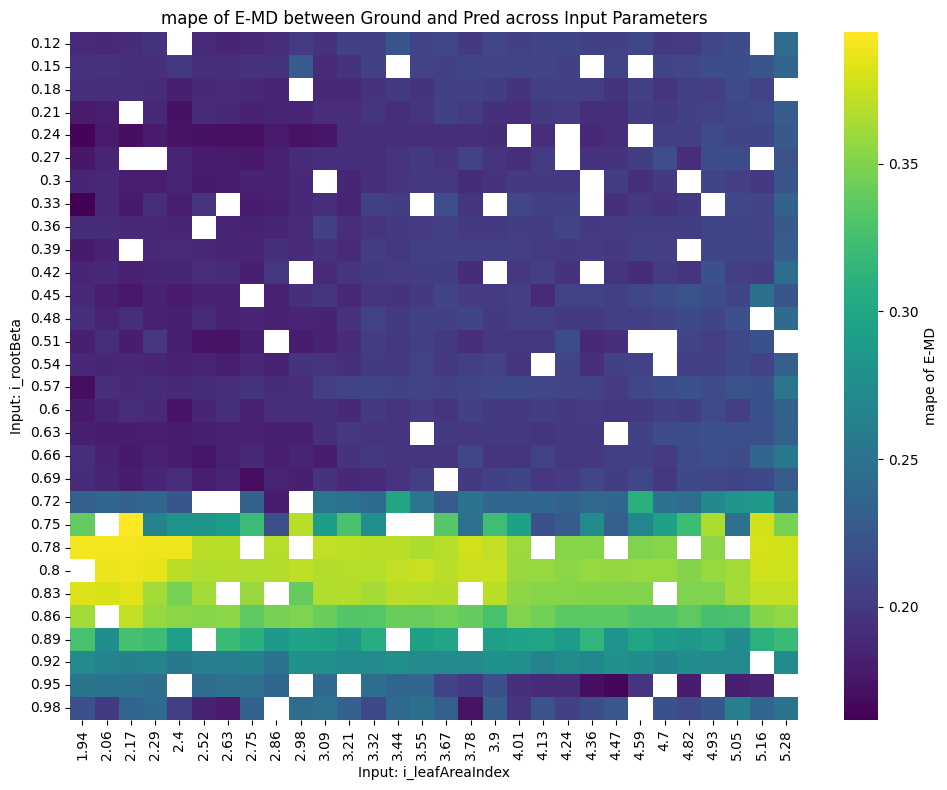

In [13]:
# Binned heatmap over errors, aggregating over the outputs and interpolating
metric = 'mape' # mse, mape, made, rmse, r2
bins = 30

if problem['num_vars'] == 2:
    for d in range(D):
        plt.figure(figsize=(10, 8))

        col = problem['outputs'][d]

        z = errors[col][metric]
        
        # Compute mean within bins
        stat, x_edges, y_edges, binnumber = binned_statistic_2d(
            x, y, z, statistic='mean', bins=bins
        )

        # Reduce number of y-tick and x-tick labels
        x_tick_labels = np.round((x_edges[:-1] + x_edges[1:]) / 2, 2)
        y_tick_labels = np.round((y_edges[:-1] + y_edges[1:]) / 2, 2)

        # Plot
        ax = sns.heatmap(
            stat.T,
            xticklabels=x_tick_labels,
            yticklabels=y_tick_labels,
            cmap='viridis',
            cbar_kws={'label': f"{metric} of {problem['outputs'][d]}"}
        )

        ax.set_xlabel(f'Input: {problem["names"][0]}')
        ax.set_ylabel(f'Input: {problem["names"][1]}')
        ax.set_title(f'{metric} of {problem["outputs"][d]} between Ground and Pred across Input Parameters')
        plt.tight_layout()
        plt.show()